In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import tensorflow as tf
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random

scaler = MinMaxScaler()
root_directory = 'segm_data/'
patch_size = 256
image_dataset = []  
mask_dataset = [] 

2023-10-29 20:21:40.460677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 20:21:40.542501: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-29 20:21:40.544845: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hanrewan/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64::/home/hanrewan/

Segmentation Models: using `tf.keras` framework.


In [2]:
for path, subdirs, files in os.walk(root_directory): 
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        for u in range(1, 10):  
            image_name = f'image_part_00{u}.jpg'
               
            image = cv2.imread(path+"/"+image_name, 1)
            SIZE_X = (image.shape[1]//patch_size)*patch_size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))
            image = np.array(image)
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)  
                    single_patch_img = single_patch_img[0]                           
                    image_dataset.append(single_patch_img)
    if dirname == 'masks':
        masks = os.listdir(path) 
        for u in range(1, 10):
            mask_name = f'image_part_00{u}.png'
            if mask_name.endswith(".png"):
               
                mask = cv2.imread(path+"/"+mask_name, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]                         
                        mask_dataset.append(single_patch_mask) 
                 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

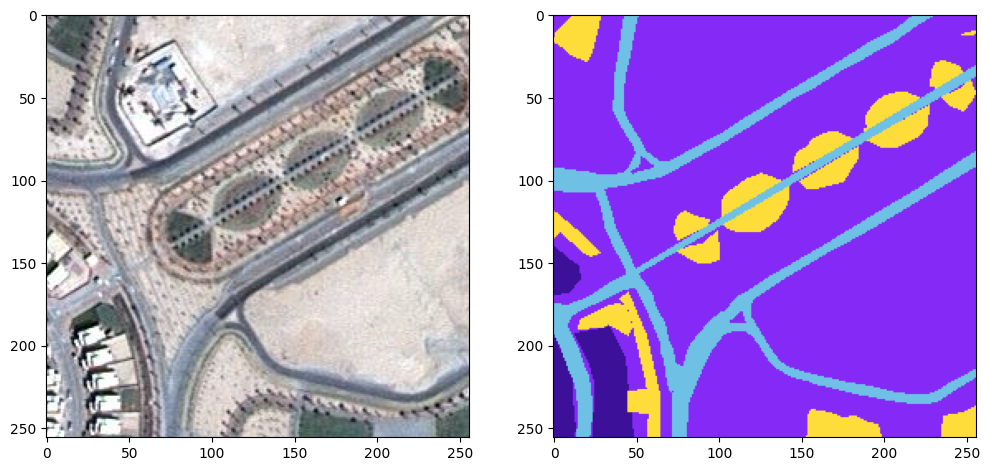

In [3]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [4]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2) 
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8) 
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [5]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

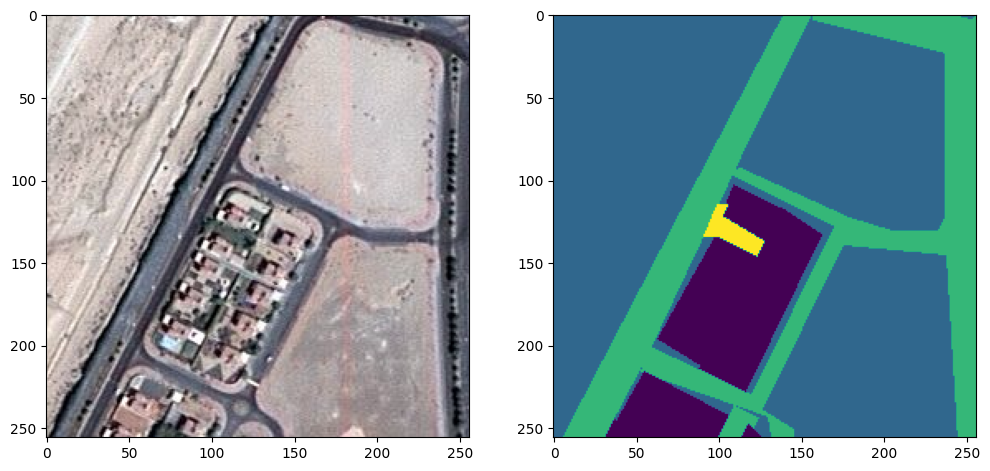

In [6]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)


image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [7]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)
image_dataset = image_dataset.astype('float32')
labels_cat = labels_cat.astype('float32')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [8]:
with tf.device("CPU"):
    weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
    dice_loss = sm.losses.DiceLoss(class_weights=weights) 
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)
    IMG_HEIGHT = X_train.shape[1]
    IMG_WIDTH  = X_train.shape[2]
    IMG_CHANNELS = X_train.shape[3]
    metrics=['accuracy', jacard_coef]
    
    model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
    model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

2023-10-29 20:21:58.680578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-29 20:21:58.680710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hanrewan/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64::/home/hanrewan/anaconda3/lib/:/home/hanrewan/anaconda3/lib/python3.8/site-packages/tensorrt/:/home/hanrewan/anaconda3/envs/tf/lib:/home/hanrewan/anaconda3/envs/tf/lib/python3.8/site-packages/tensorrt/
2023-10-29 20:21:58.680746: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file 

 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 16  4624        ['concatenate_3[0][0]']          
          

In [9]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [10]:
#history = model.fit(X_train, y_train, batch_size = 1, verbose=16, epochs=10, validation_data=(X_test, y_test), shuffle=False)

In [11]:
model.load_weights('models/U_net/segmentation_1.h5')
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################################
#Predict on a few images

9/9 [==============================] - 5s 503ms/step
Mean IoU = 0.53952605


1/1 [==============================] - 0s 40ms/step


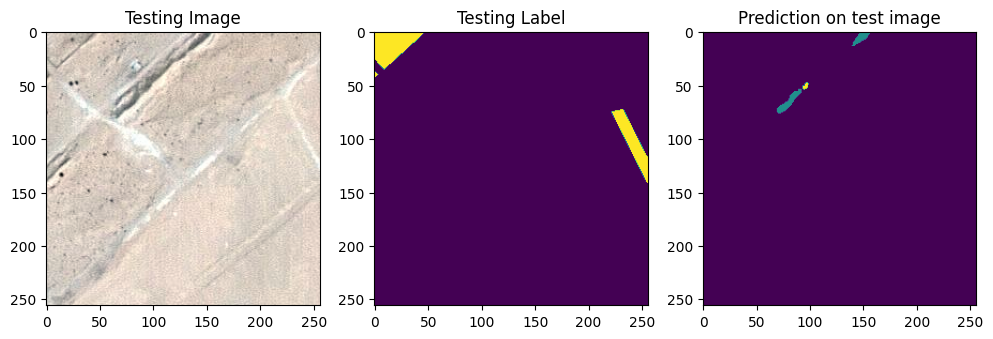

1/1 [==============================] - 0s 32ms/step


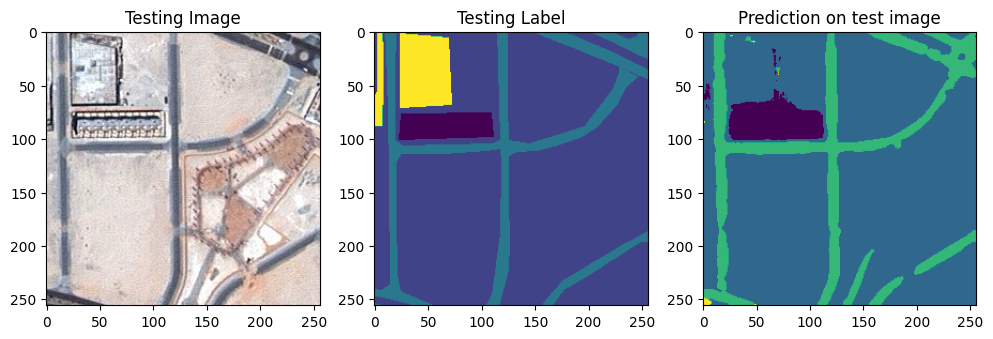

1/1 [==============================] - 0s 33ms/step


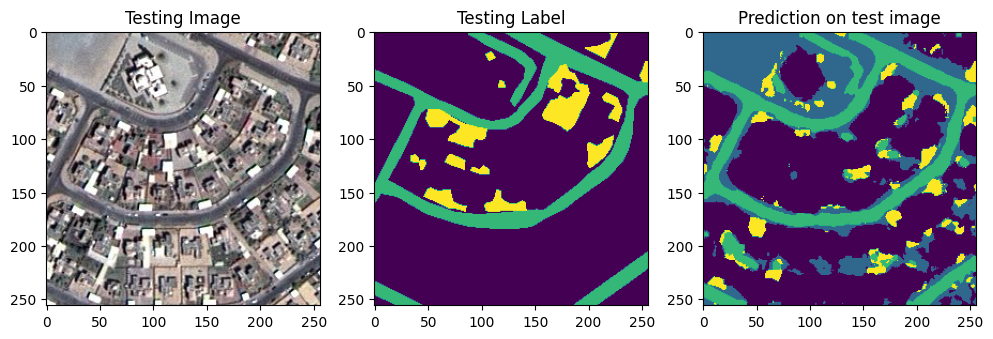

1/1 [==============================] - 0s 32ms/step


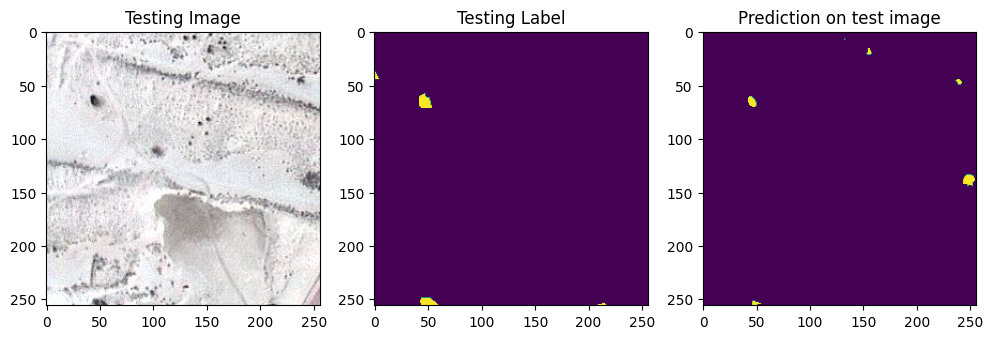

1/1 [==============================] - 0s 35ms/step


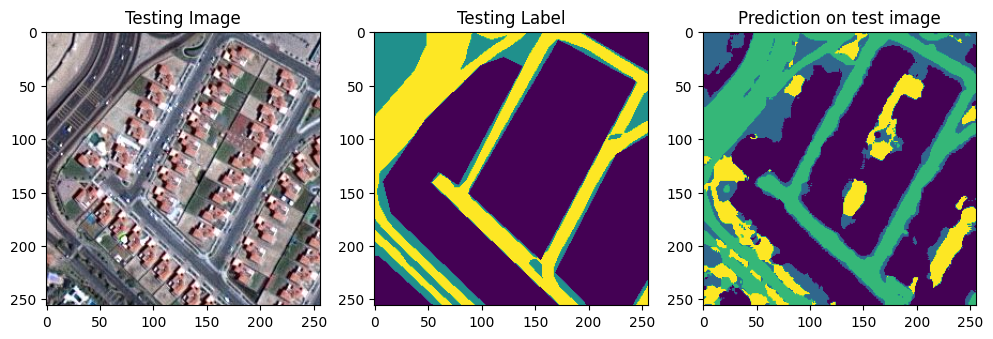

1/1 [==============================] - 0s 34ms/step


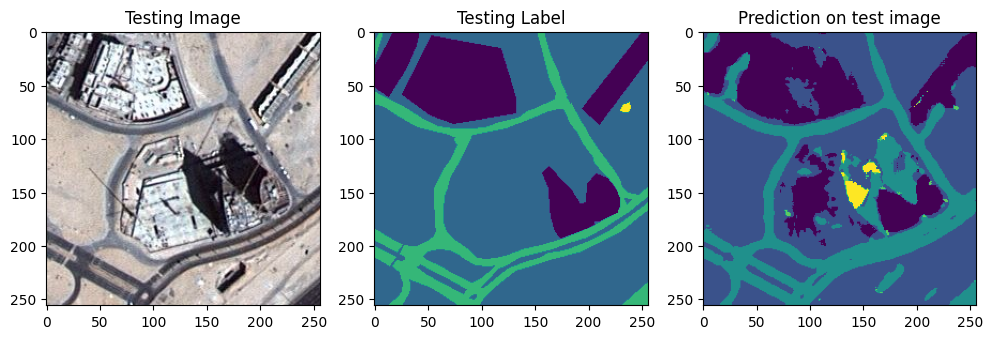

1/1 [==============================] - 0s 41ms/step


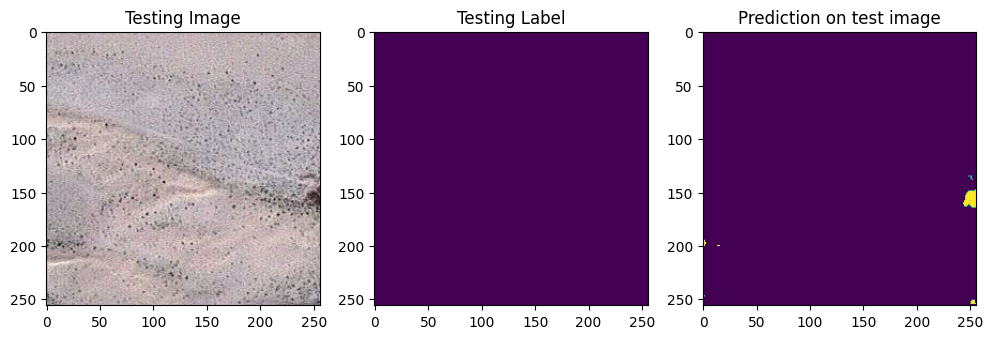

1/1 [==============================] - 0s 33ms/step


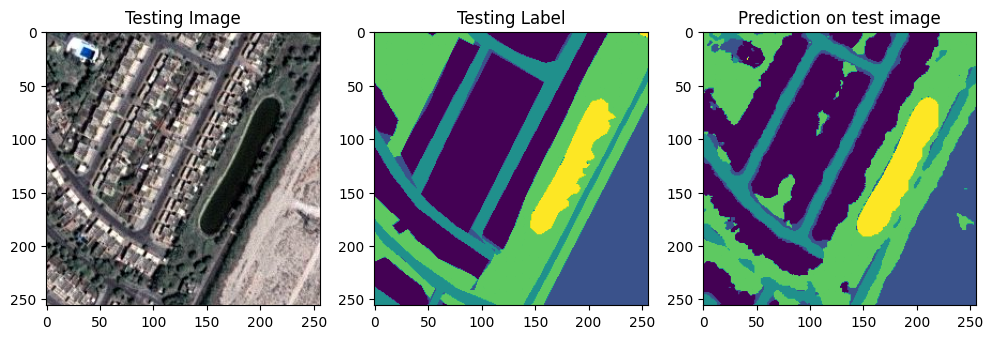

1/1 [==============================] - 0s 32ms/step


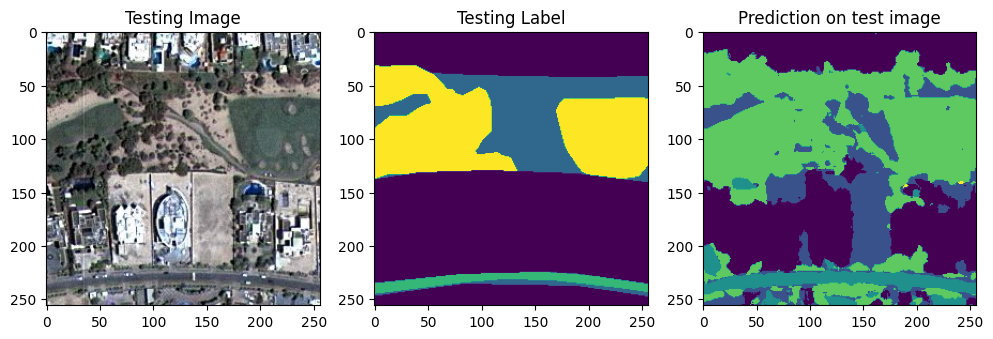

In [12]:
import random

def test():
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    #test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    
    
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img)
    plt.show()

for i in range(9):
    test()

In [13]:
from typing import Any, Optional, Tuple
import matplotlib.pyplot as plt

def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: Optional[Tuple[float, float]] = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [14]:
def proc_img(image):
    SIZE_X = (image.shape[1]//patch_size)*patch_size
    SIZE_Y = (image.shape[0]//patch_size)*patch_size
    image = Image.fromarray(image)
    image = image.crop((0 ,0, SIZE_X, SIZE_Y))
    image = np.array(image)
    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    return patches_img

(256, 256, 3)


ValueError: in user code:

    File "/home/hanrewan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/home/hanrewan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/hanrewan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/home/hanrewan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/home/hanrewan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/hanrewan/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(32, 256, 3)


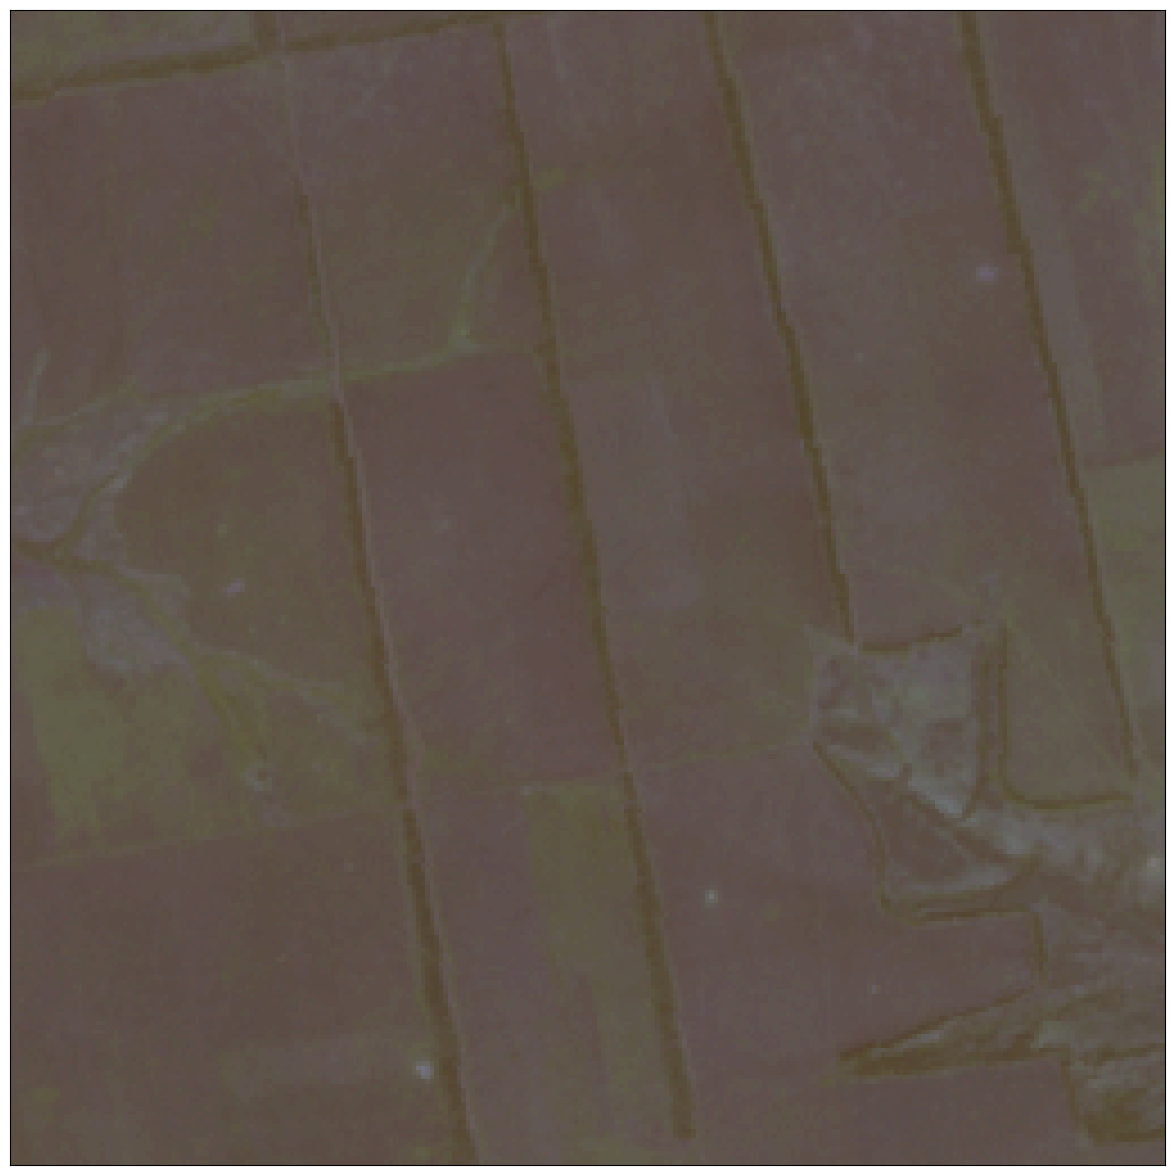

In [15]:
import cv2
import numpy as np

# Function for segmenting a tile (replace with your model)
def segment_tile(tile):
    print(tile.shape)
    return model.predict(tile)

# Load the larger image
large_image = cv2.imread('ZapUkr_2023_08_31_36738247_47575448_37061005_47803009.tiff')  # Replace with your image path
tile_size = (256, 256)
overlap = 50  # Adjust the overlap as needed

# Initialize an empty segmentation map
segmentation_map = np.zeros_like(large_image)

# Define the step size for sliding the window
step_x = tile_size[1] - overlap
step_y = tile_size[0] - overlap

# Iterate through the image using tiles
for y in range(0, 500, step_y):
    for x in range(0, 500, step_x):
        tile = large_image[y:y+tile_size[0], x:x+tile_size[1]]

        if tile.shape[0] == tile_size[0] and tile.shape[1] == tile_size[1]:
            SIZE_X = (tile.shape[1]//patch_size)*patch_size
            SIZE_Y = (tile.shape[0]//patch_size)*patch_size
            tile = Image.fromarray(tile)
            tile = tile.crop((0 ,0, SIZE_X, SIZE_Y))
            tile = np.array(tile)
            plot_image(tile, factor=3.5 / 255, clip_range=(0, 1))

# Reshape the tile to match the model's expected input shape
              # Add a batch dimension

# Now, you can use model.predict on this 'tile'
            
            segmented_tile = segment_tile(tile)

            # Paste the segmented tile into the segmentation map
            segmentation_map[y:y+tile_size[0], x:x+tile_size[1]] = segmented_tile

# Save or display the final segmentation map
cv2.imwrite('segmentation_map.jpg', segmentation_map)
plot_image(segmentation_map, factor=3.5 / 255, clip_range=(0, 1))

In [16]:
large_image.shape

(2463, 2490, 3)

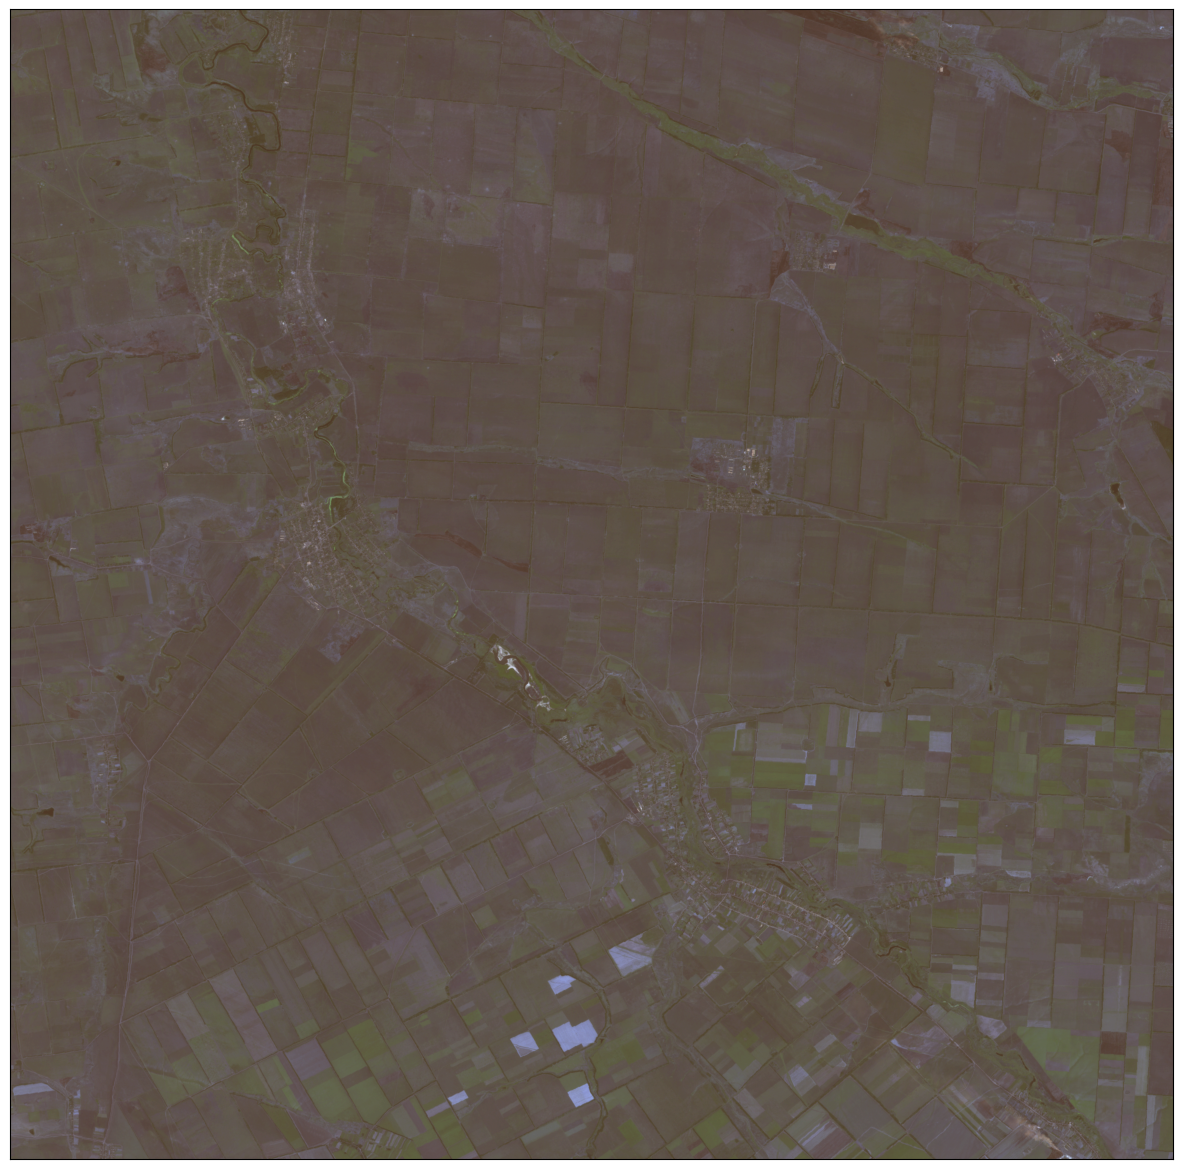

In [17]:
import cv2
import numpy as np
from PIL import Image

# Function for segmenting a tile (replace with your model)
def segment_tile(tile):
    return model.predict(tile)  # Add a batch dimension

large_image = cv2.imread('ZapUkr_2023_08_31_36738247_47575448_37061005_47803009.tiff')
tile_size = (256, 256)
overlap = 50 


# Initialize an empty segmentation map
segmentation_map = np.zeros((large_image.shape[0], large_image.shape[1], 6), dtype=np.float32)  # Corrected size and data type

# Define the step size for sliding the window
step_x = tile_size[1] - overlap
step_y = tile_size[0] - overlap
plot_image(large_image, factor=3.5 / 255, clip_range=(0, 1))



1/1 [==============================] - 0s 32ms/step


error: OpenCV(4.8.1) /io/opencv/modules/imgcodecs/src/loadsave.cpp:703: error: (-215:Assertion failed) image.channels() == 1 || image.channels() == 3 || image.channels() == 4 in function 'imwrite_'


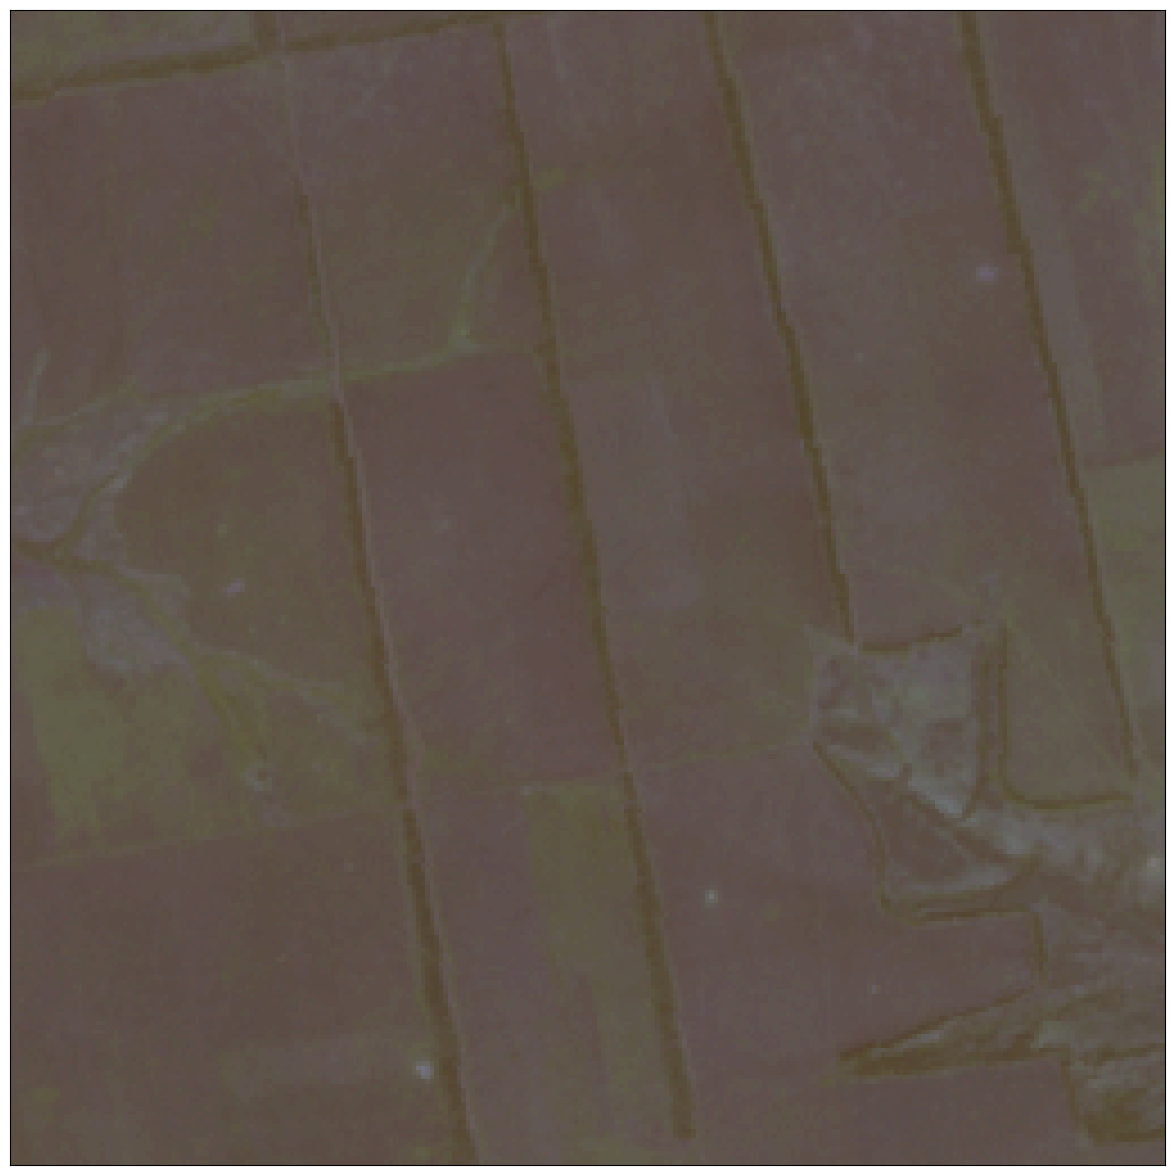

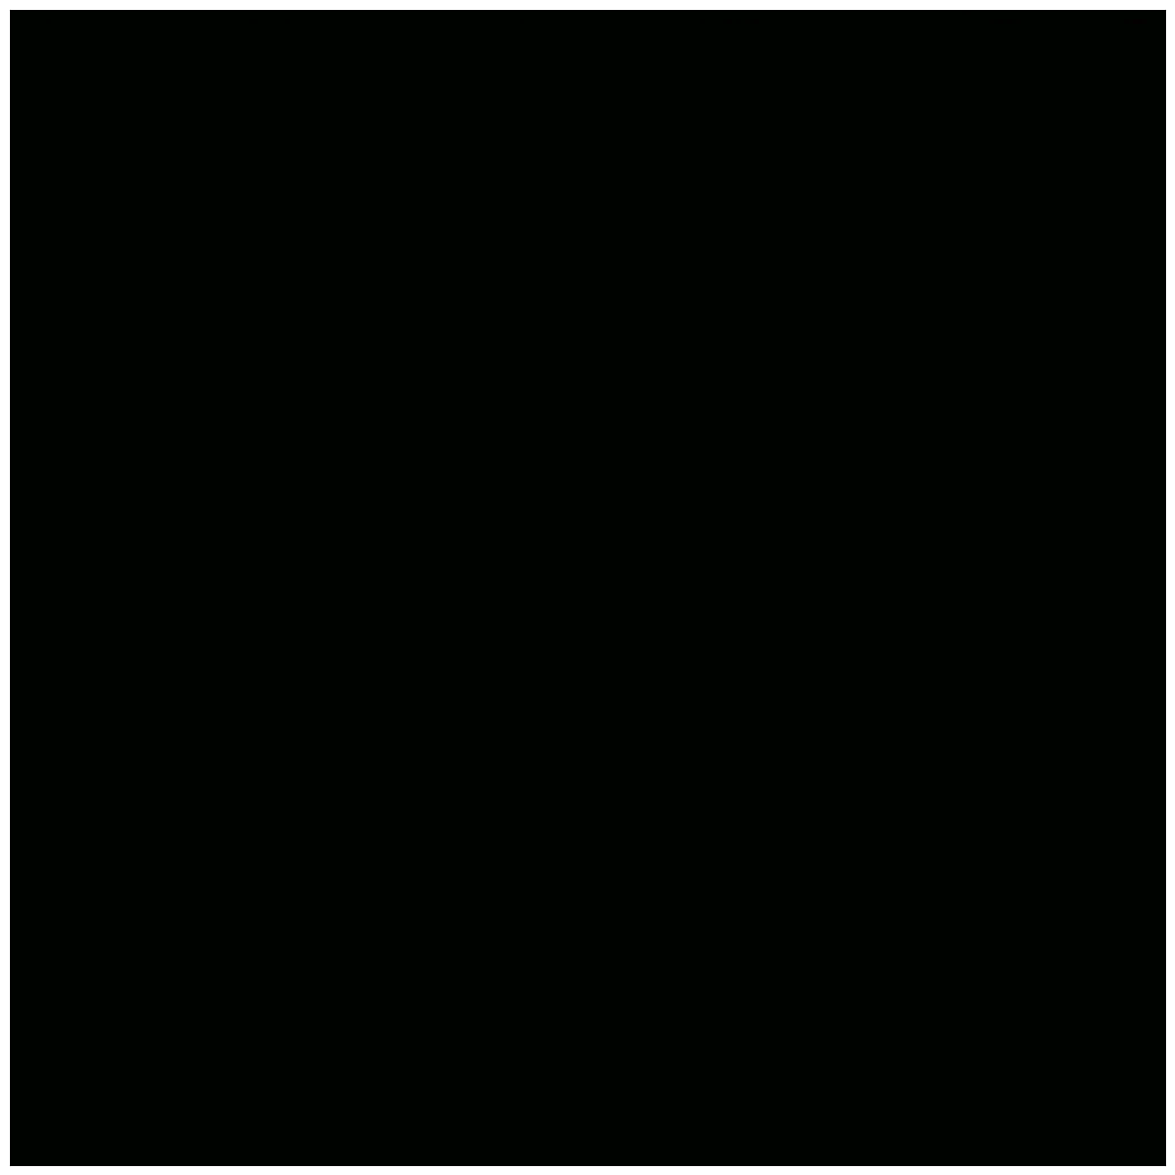

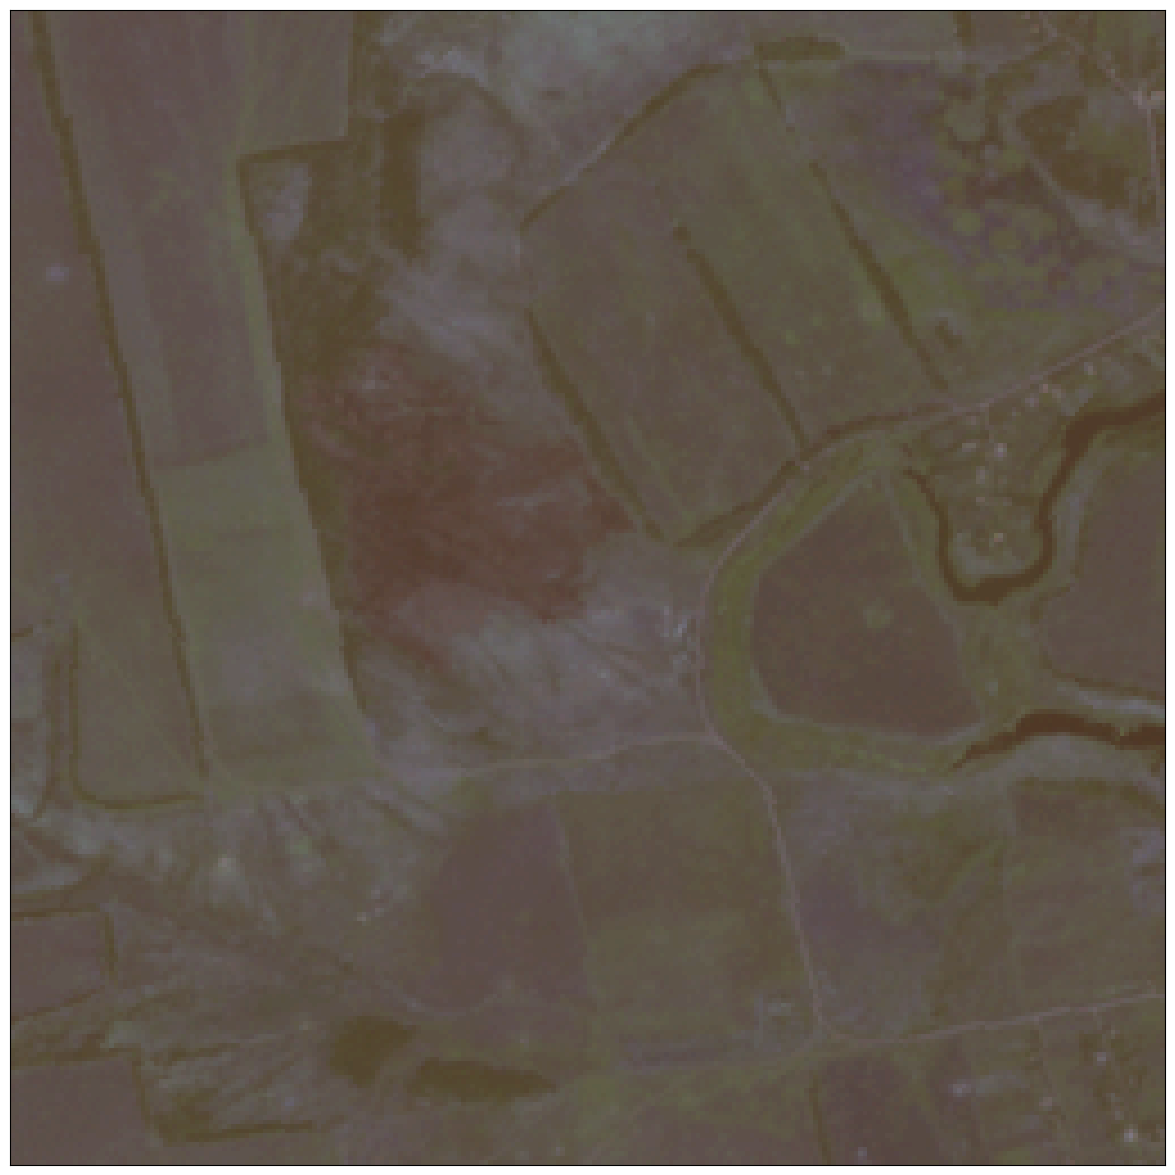

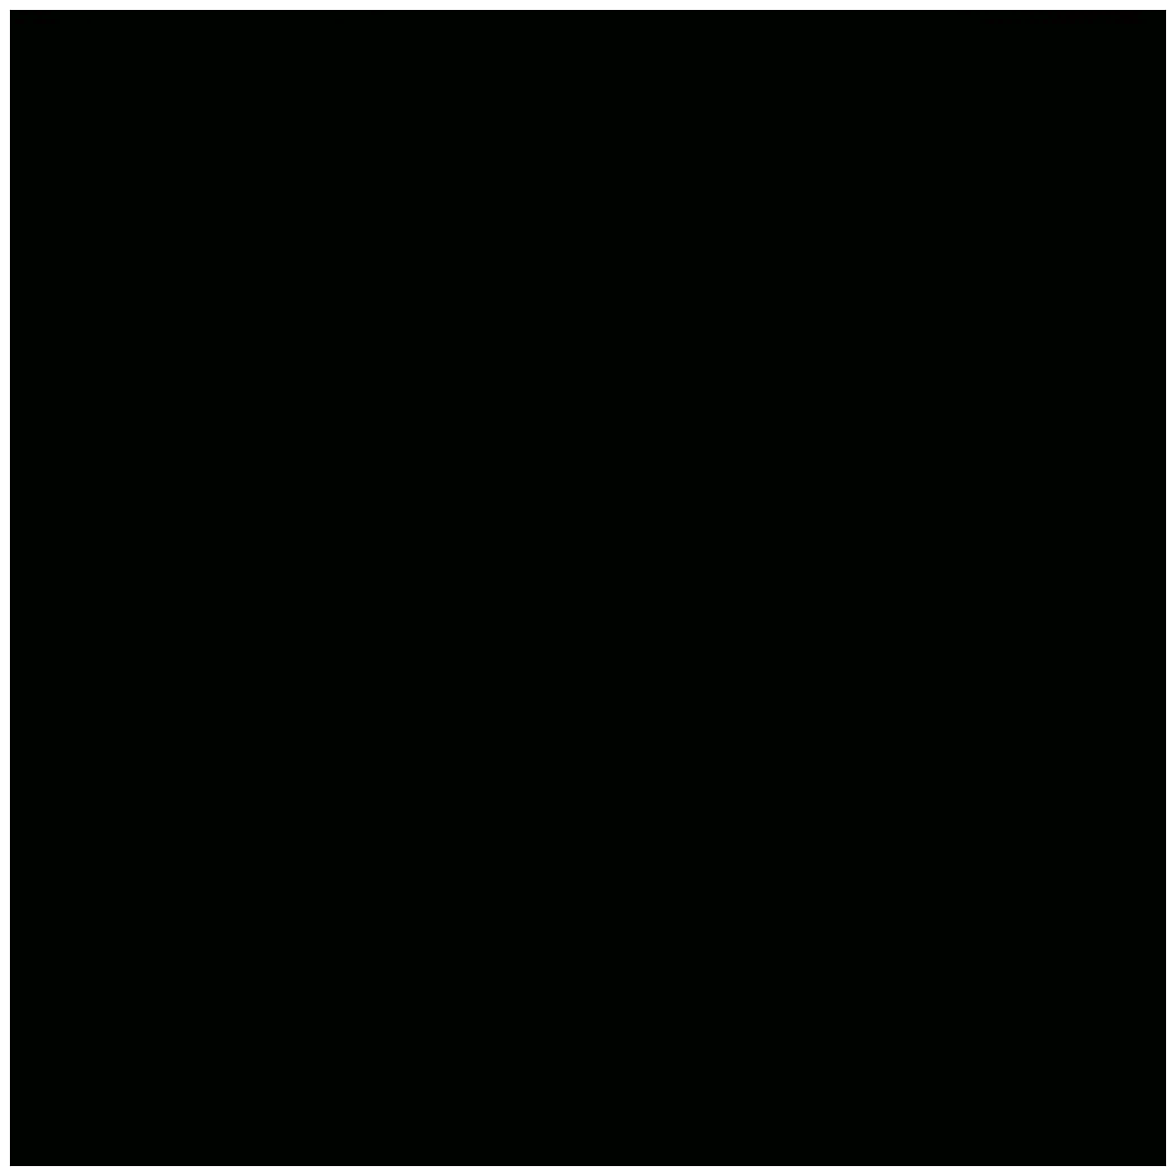

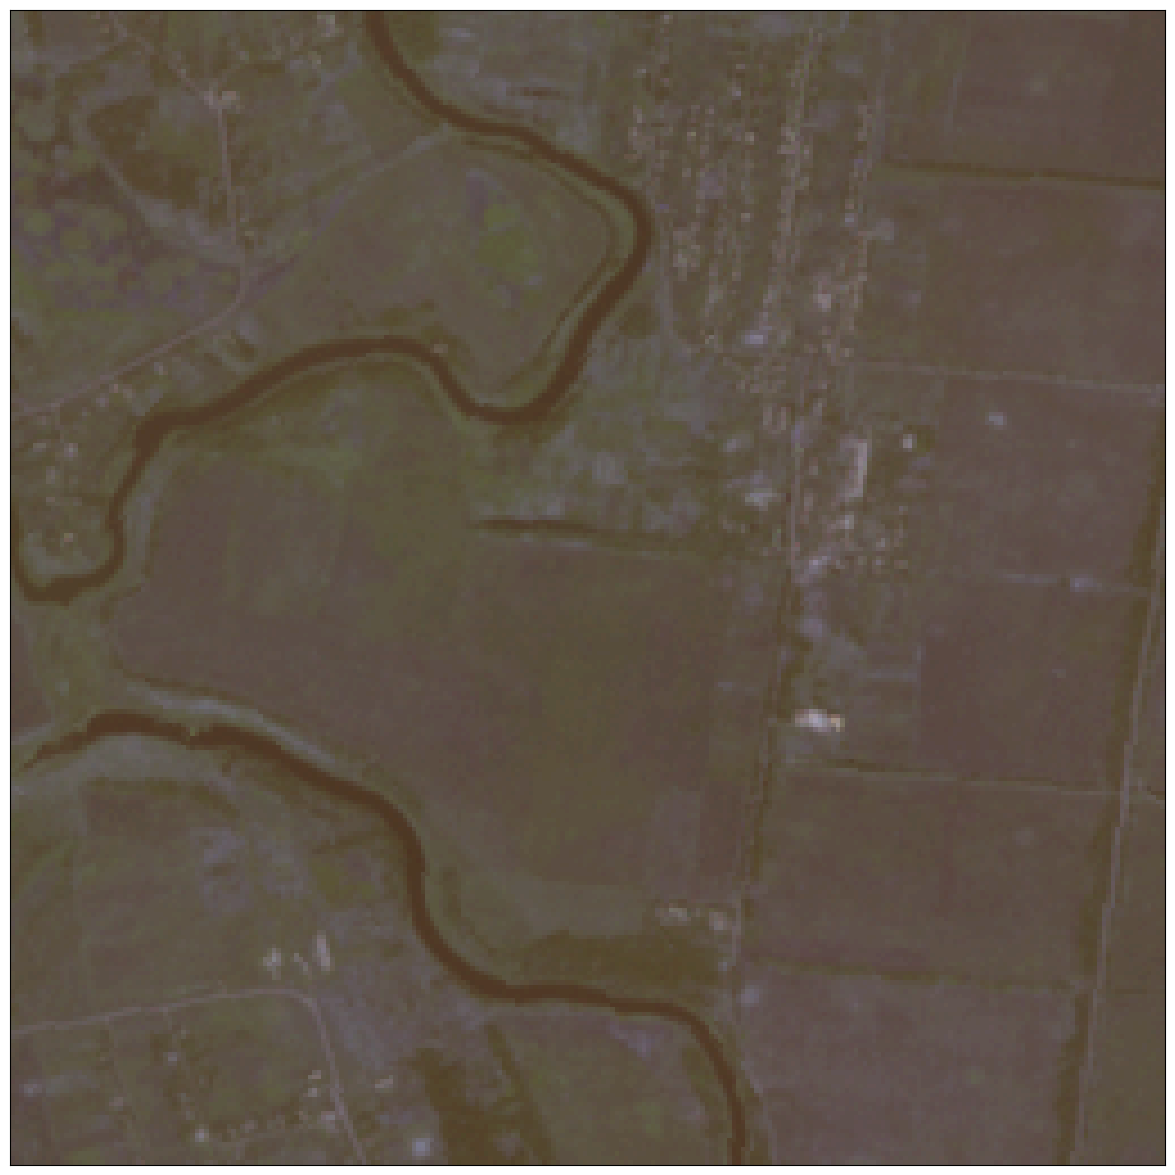

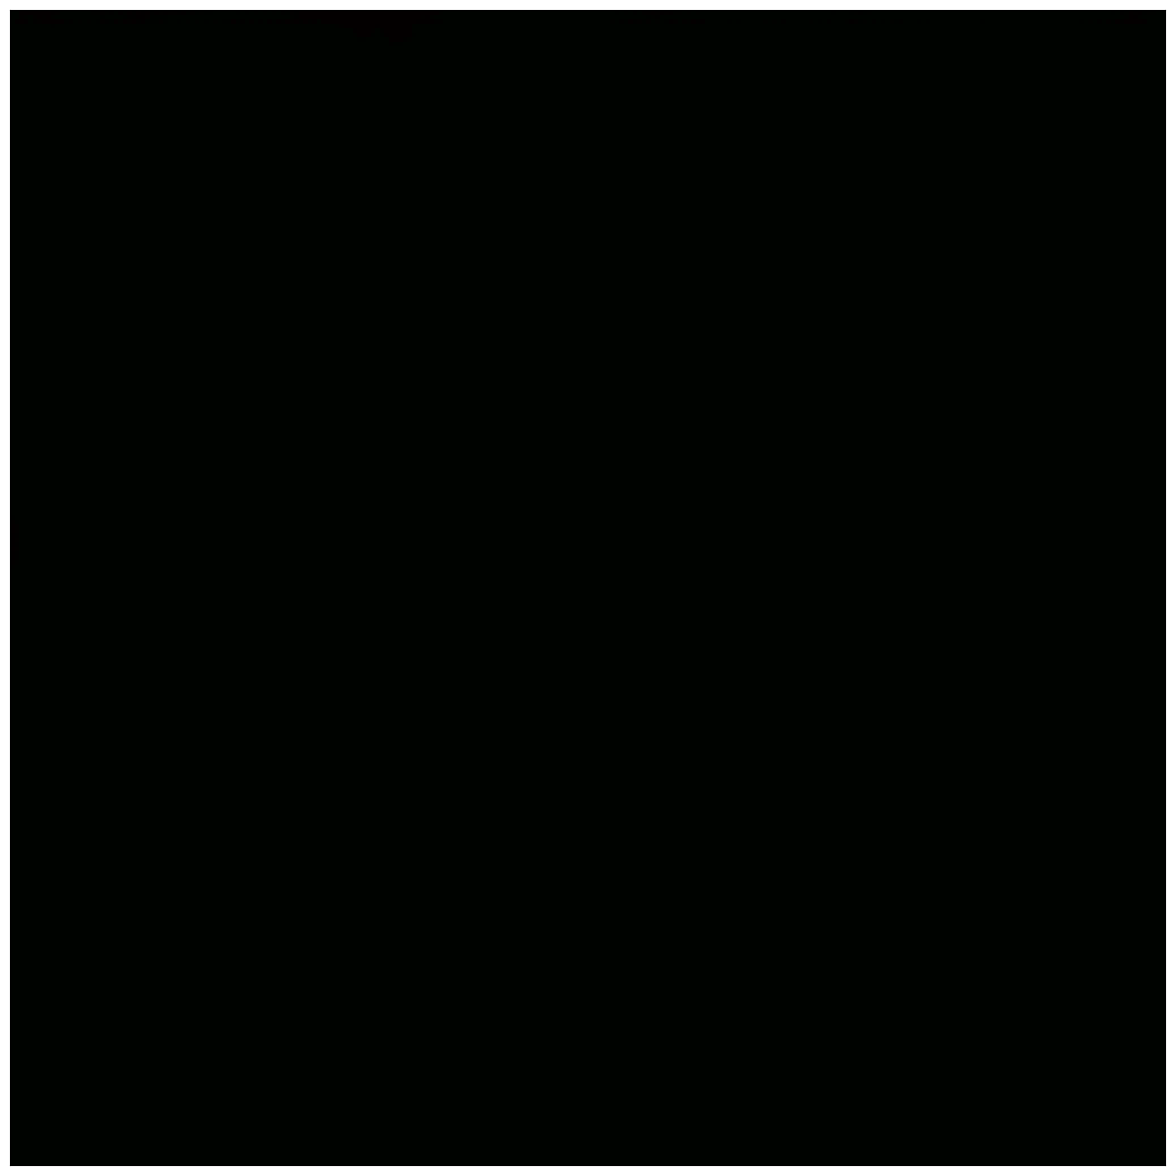

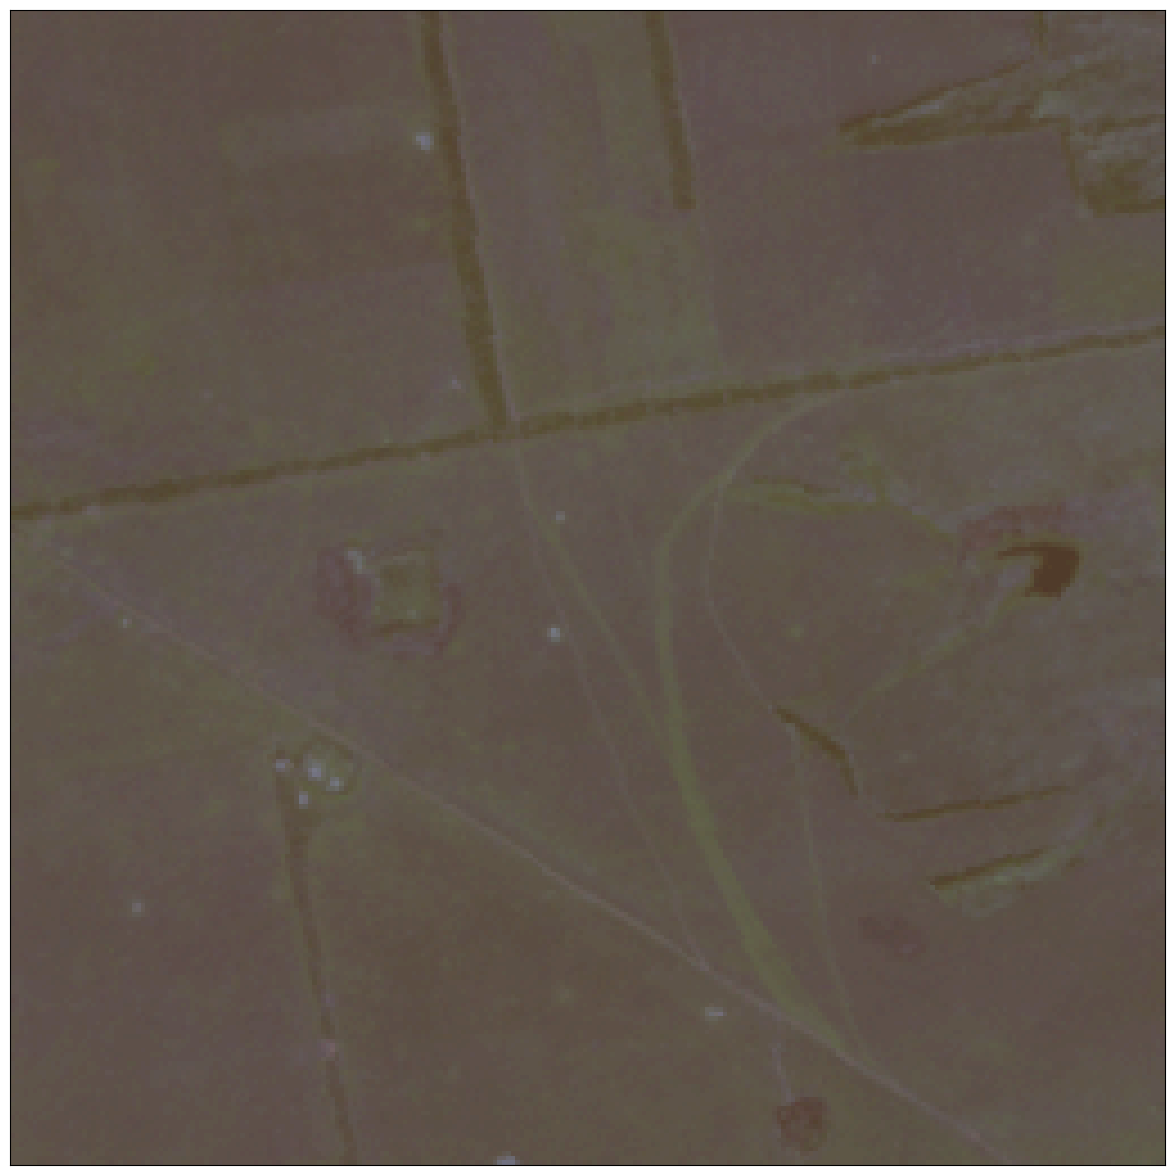

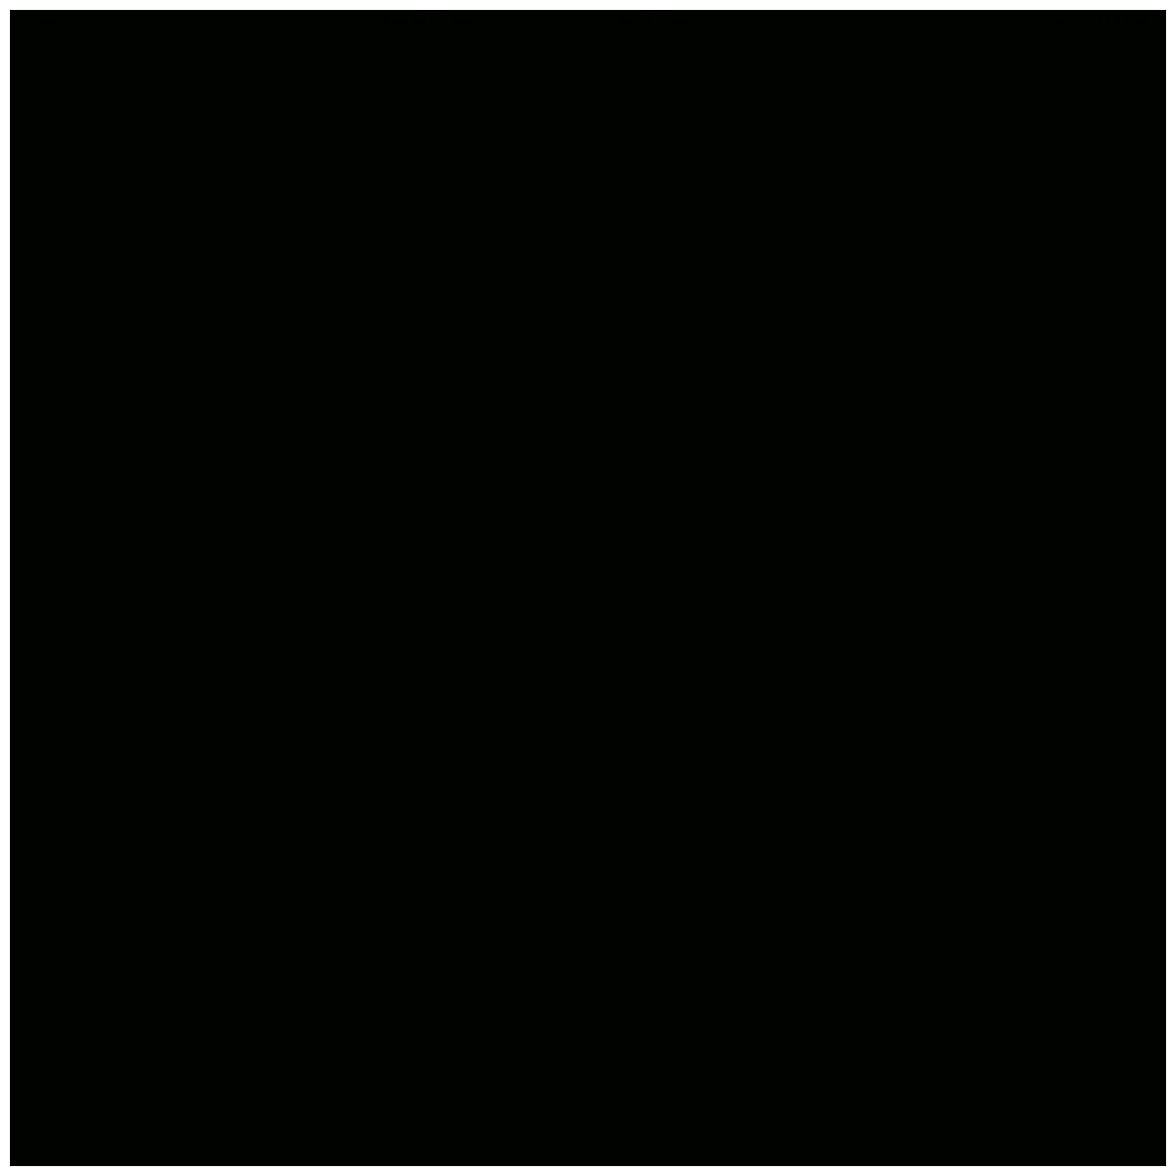

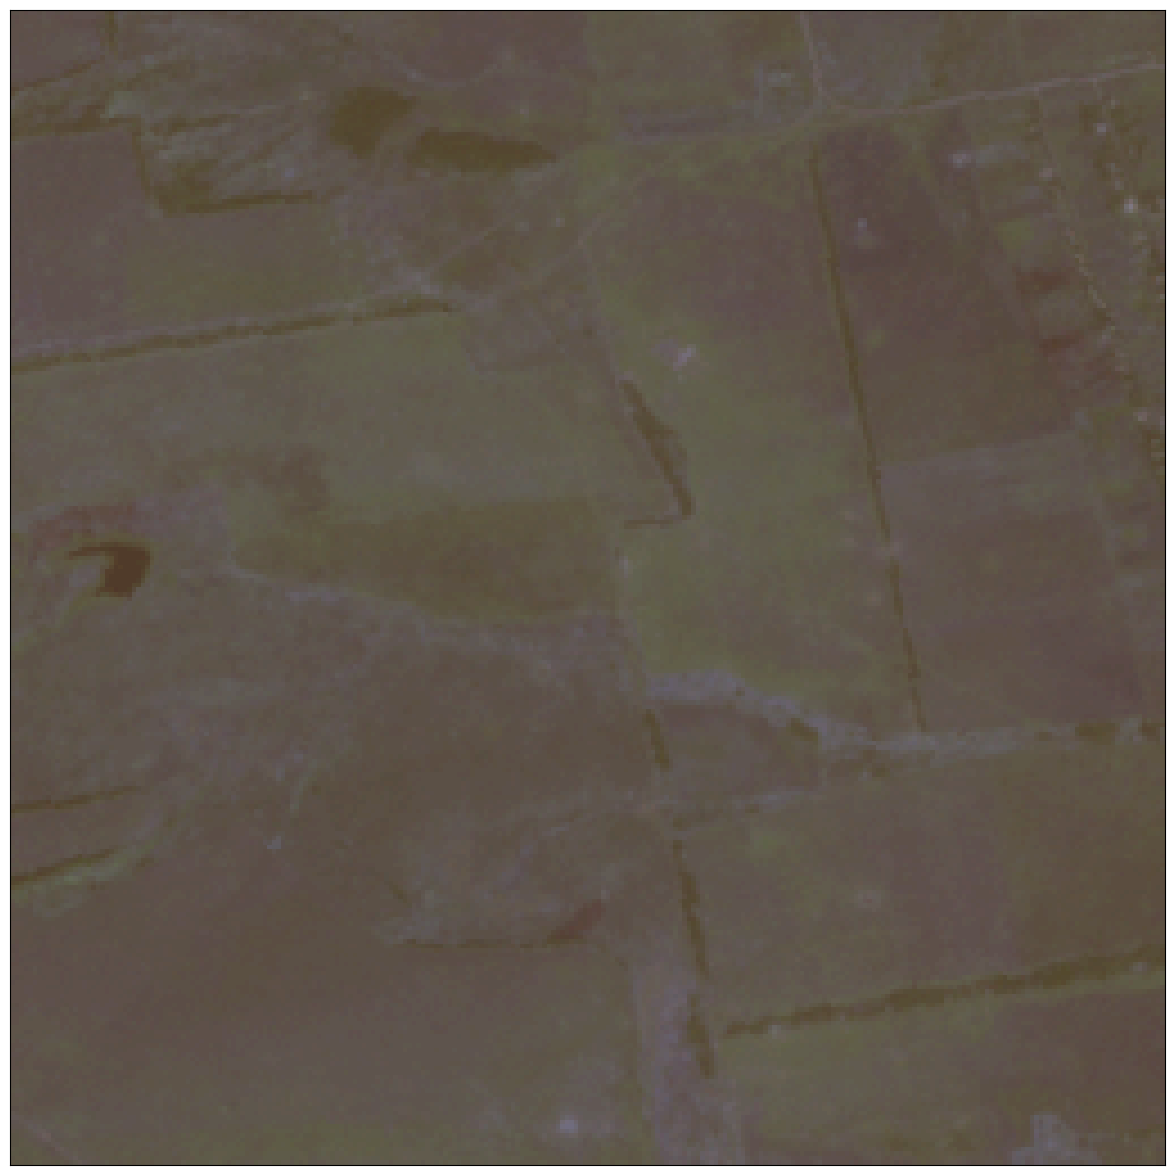

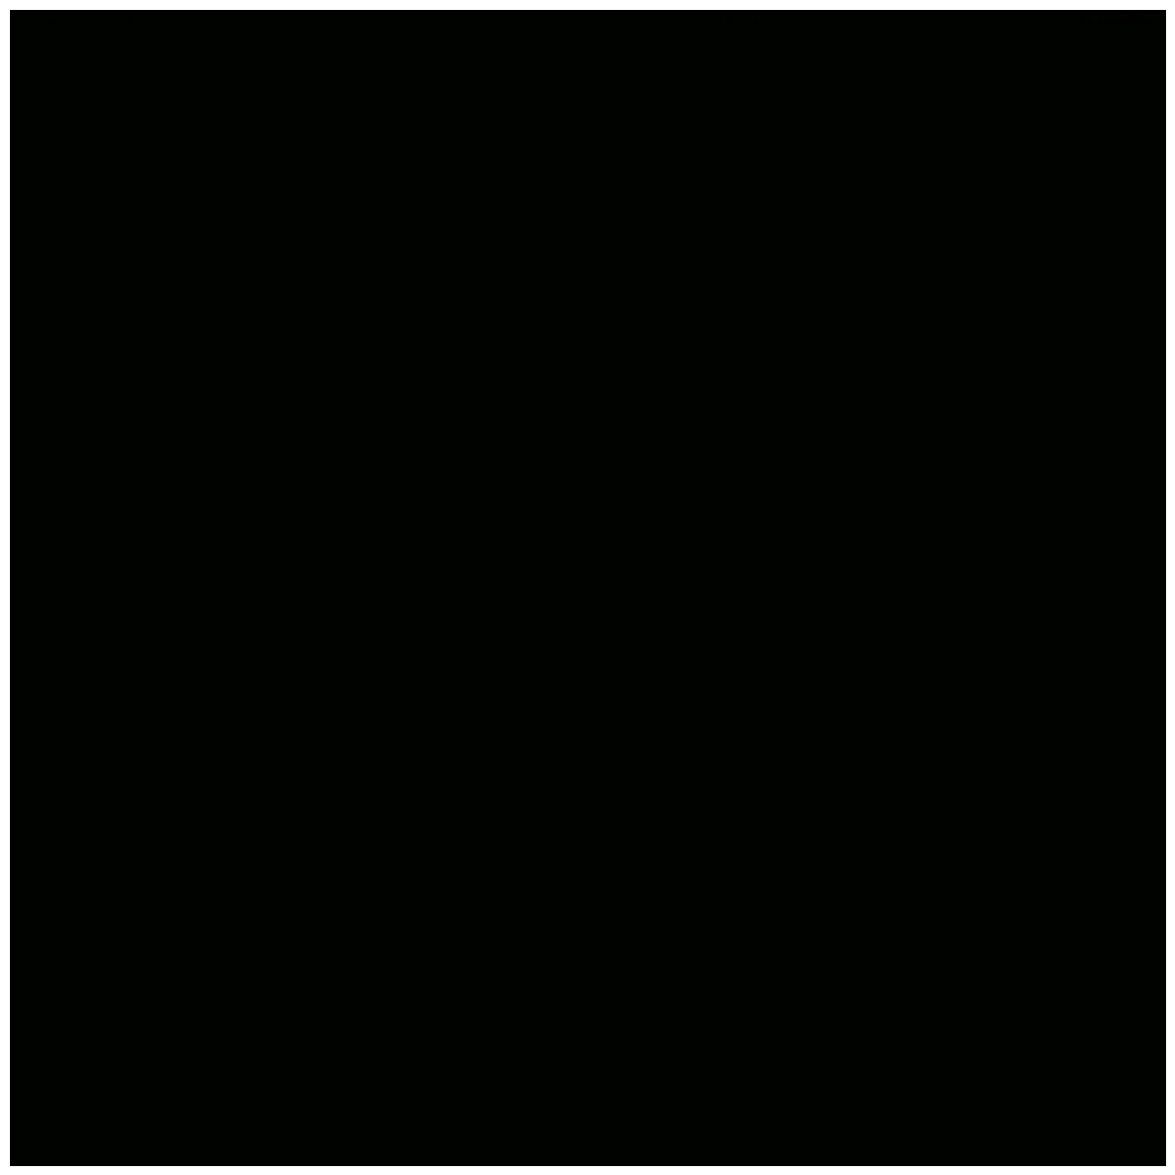

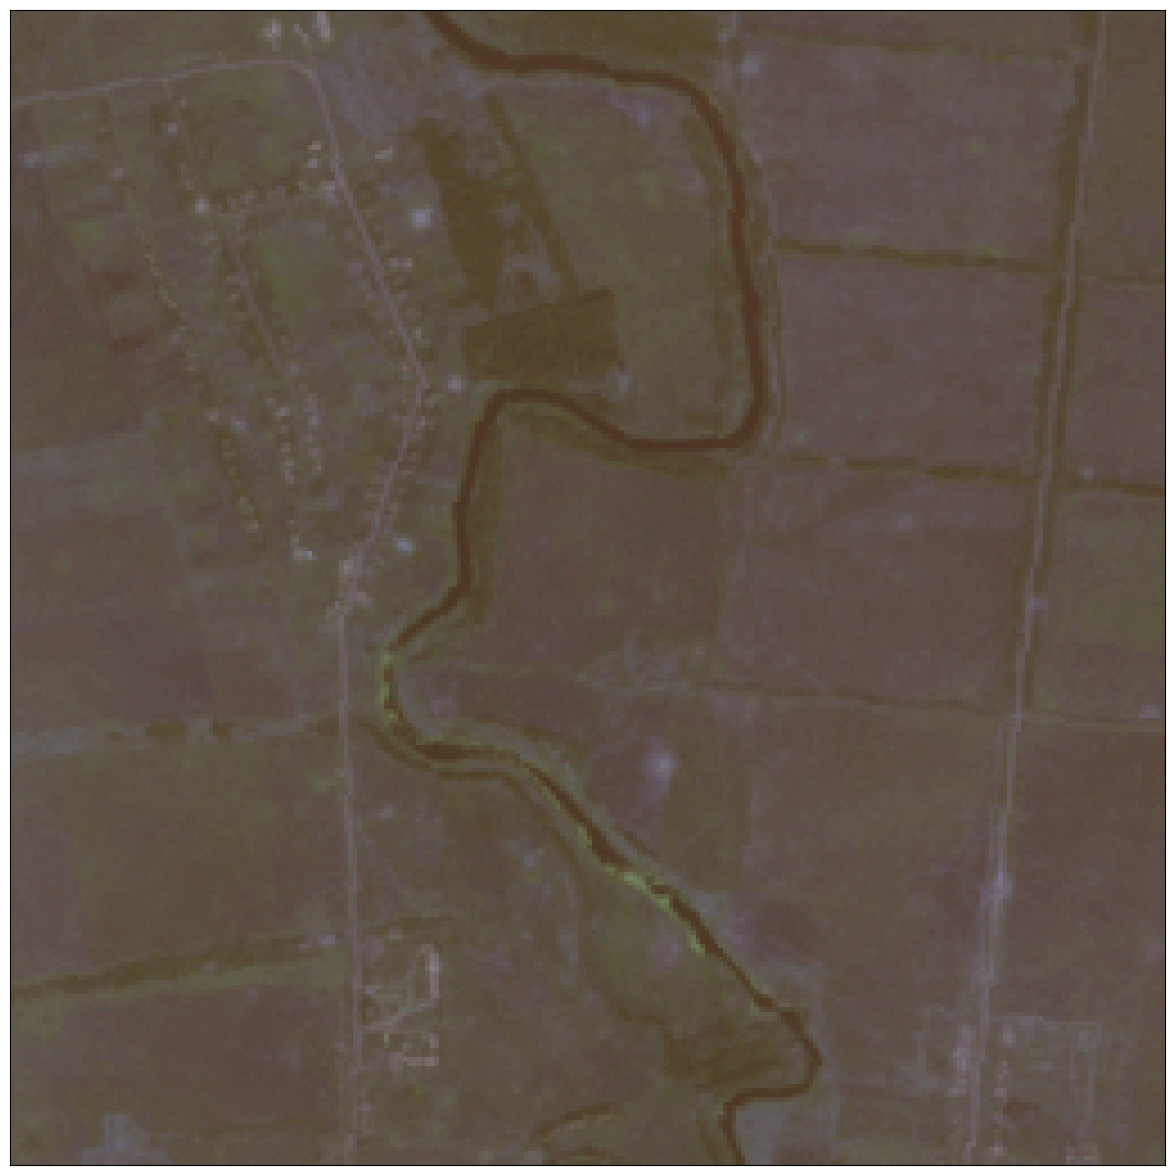

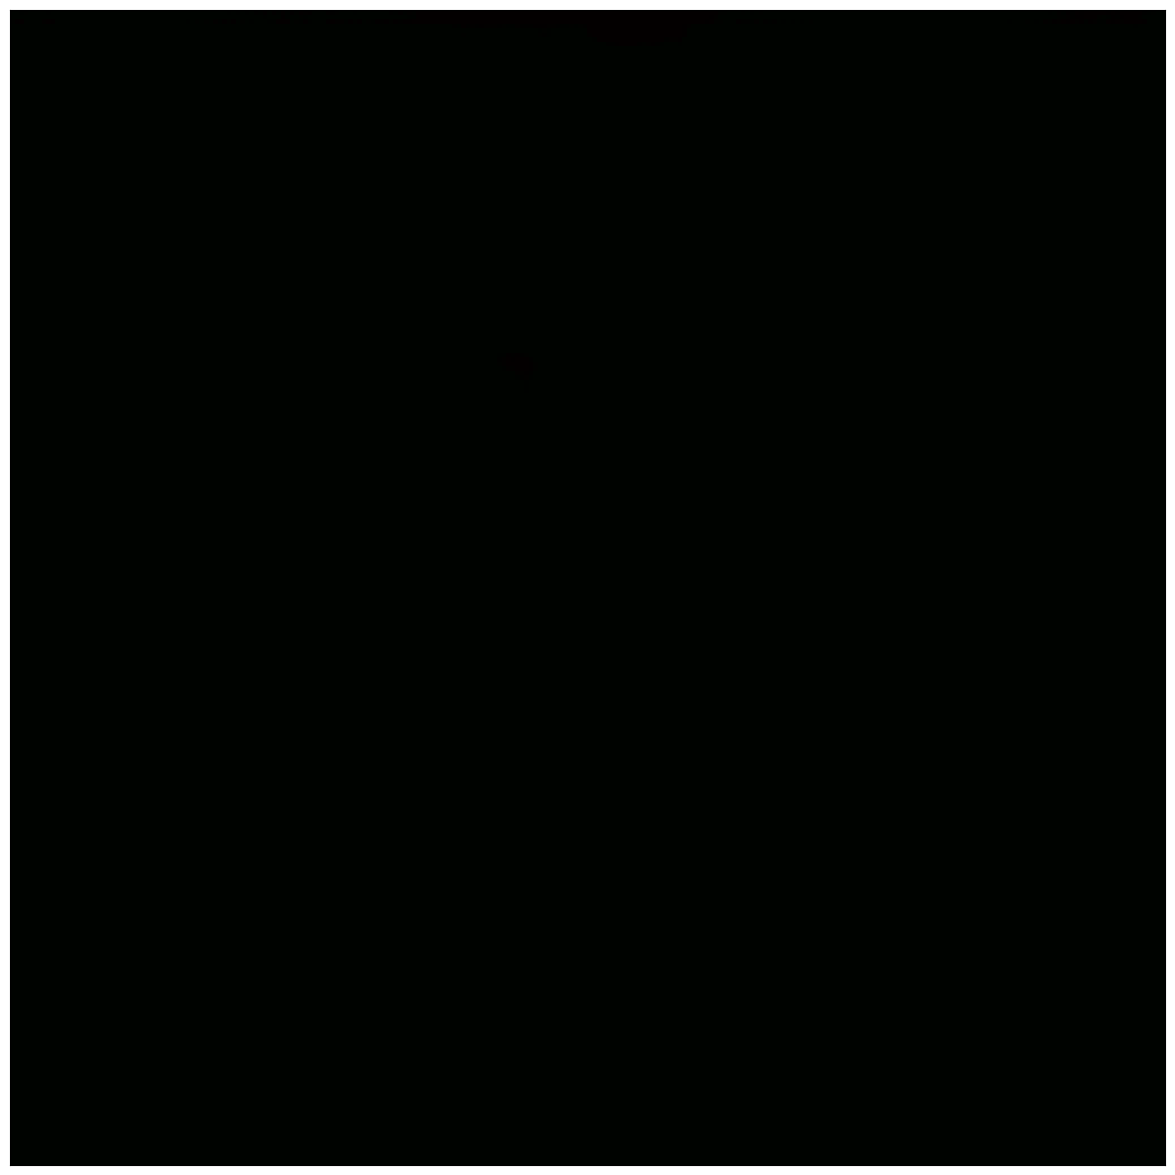

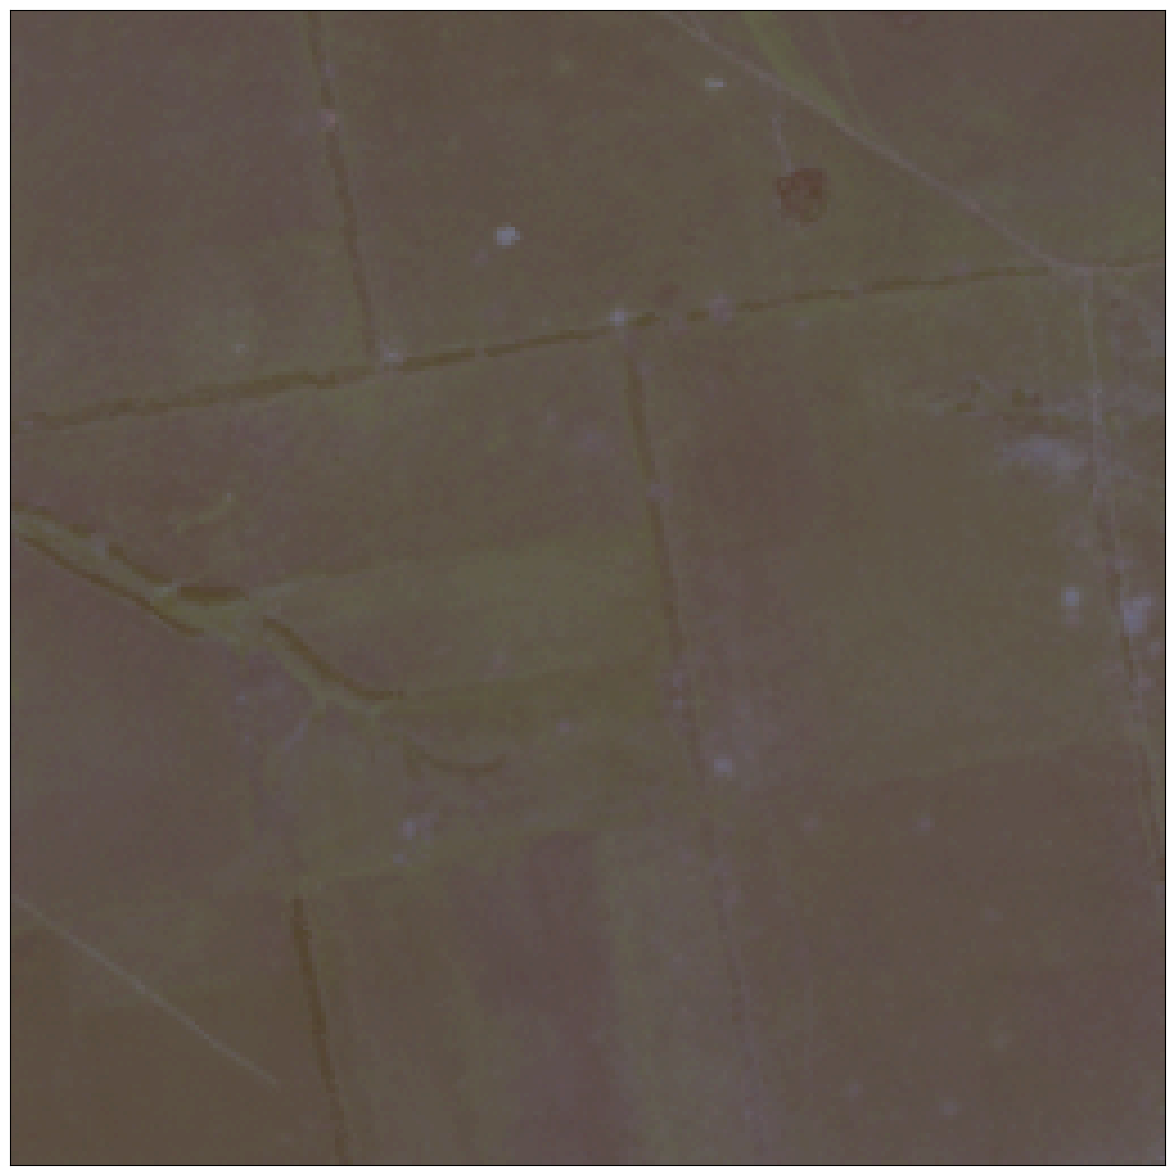

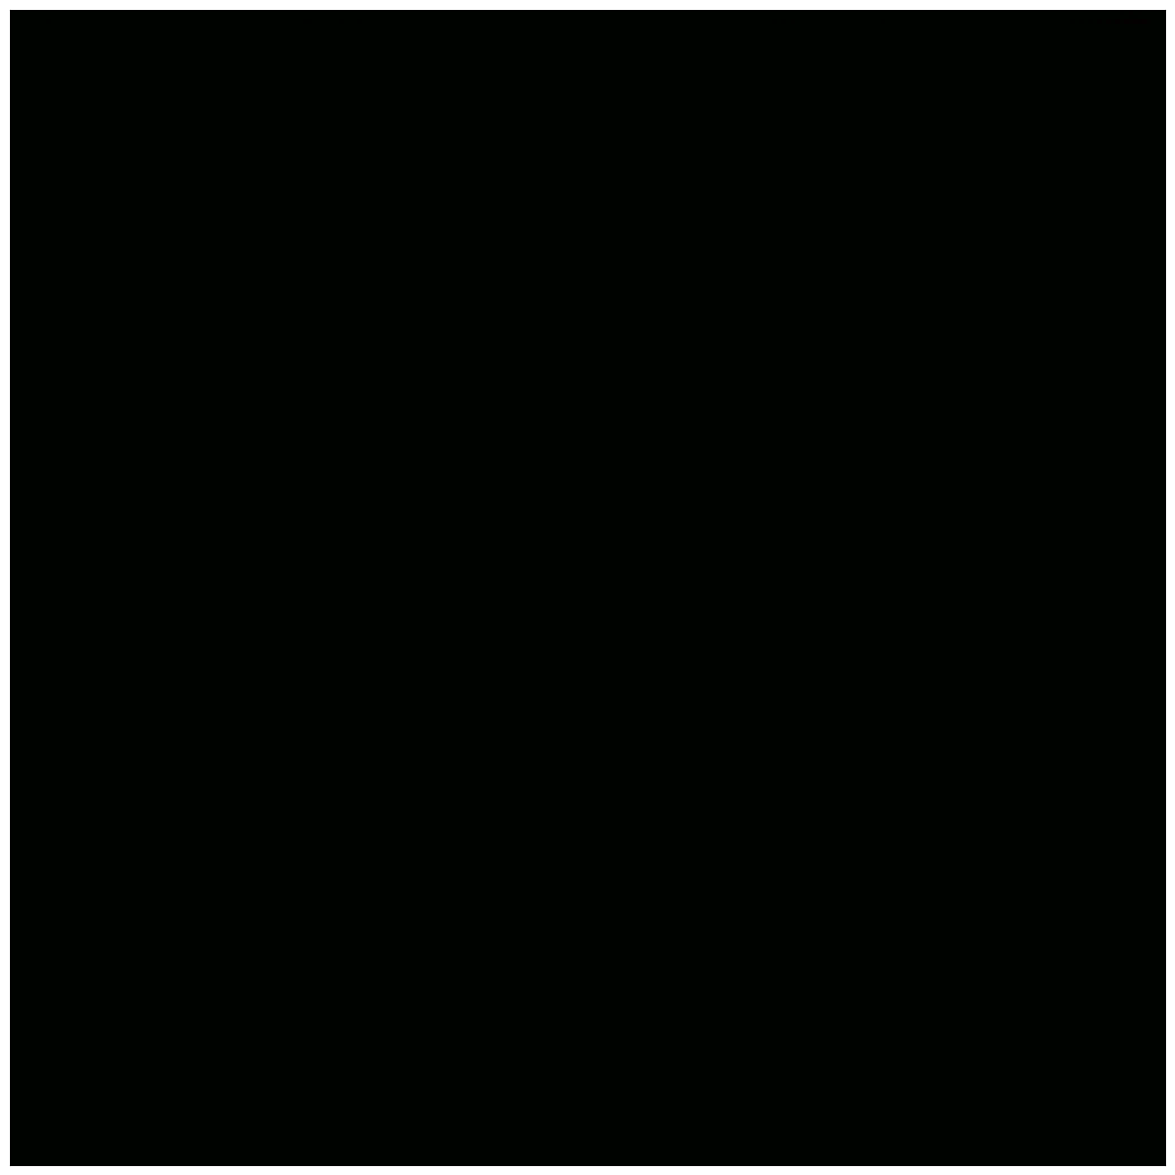

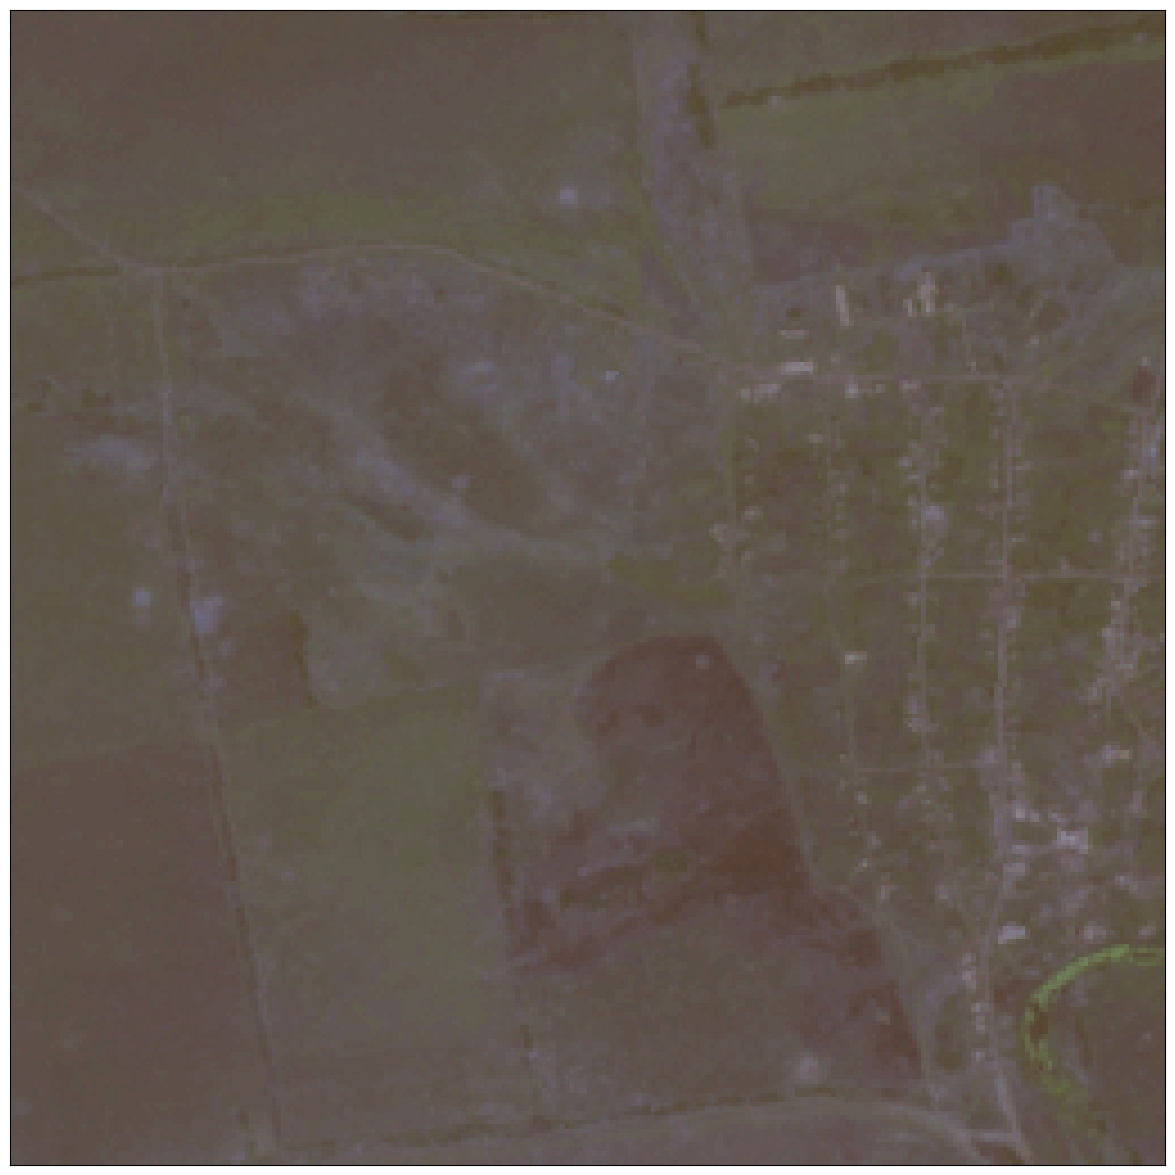

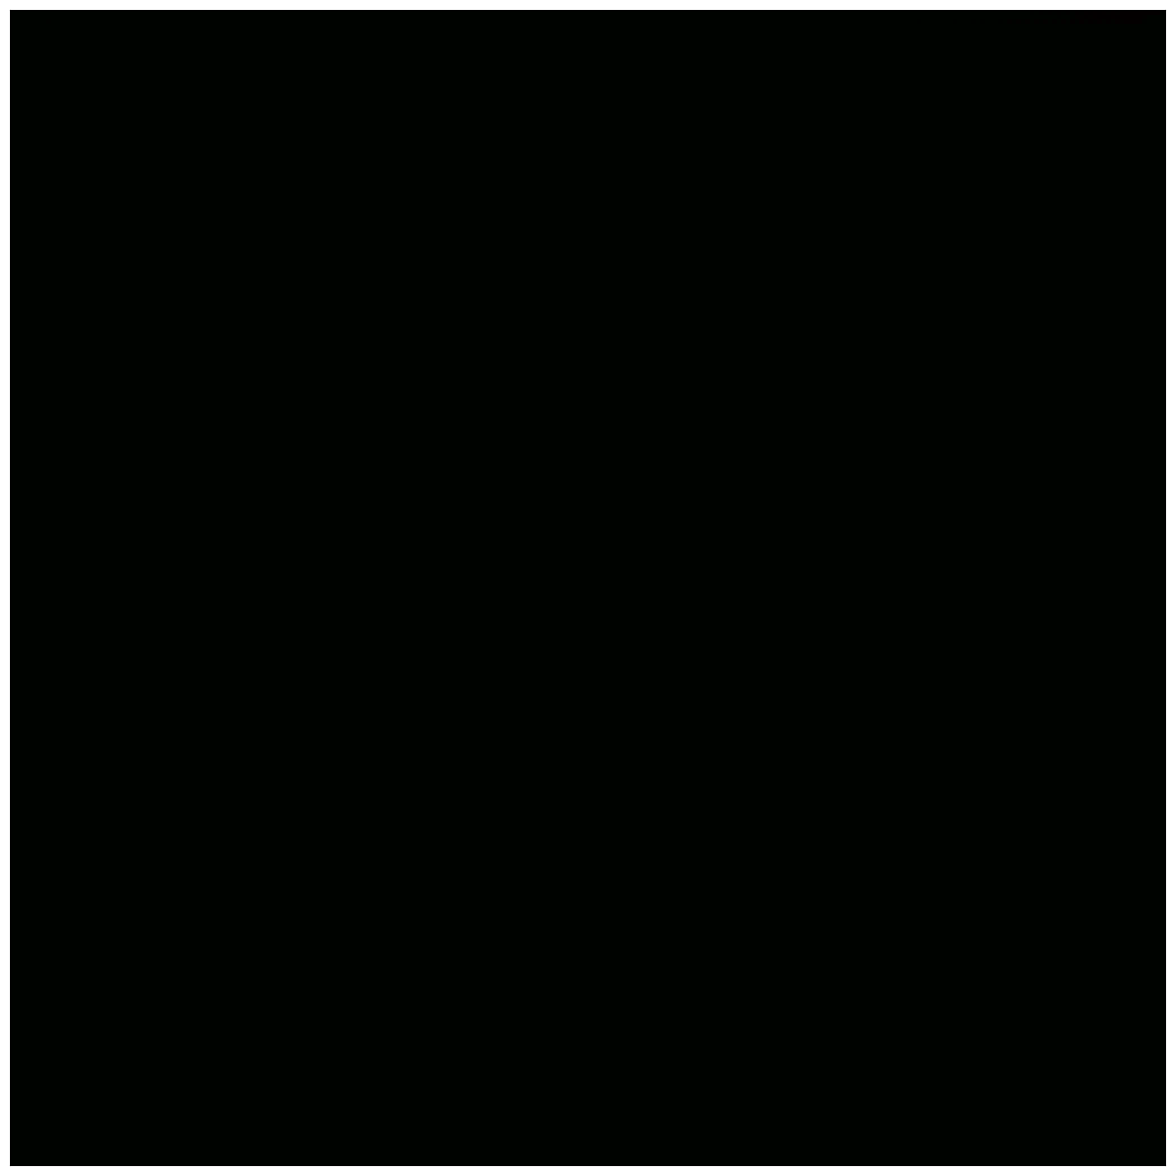

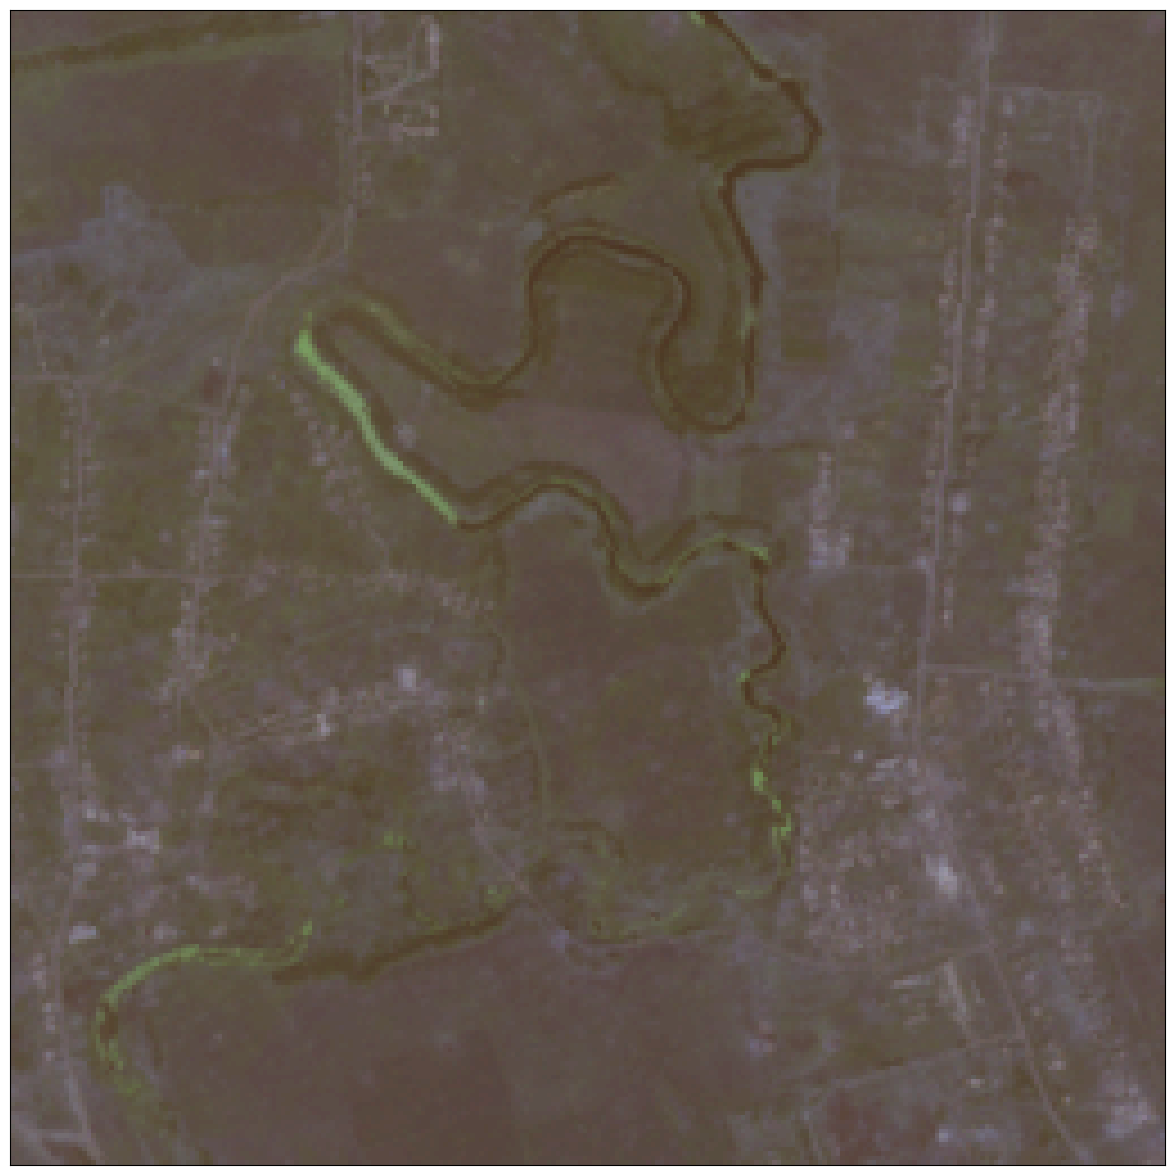

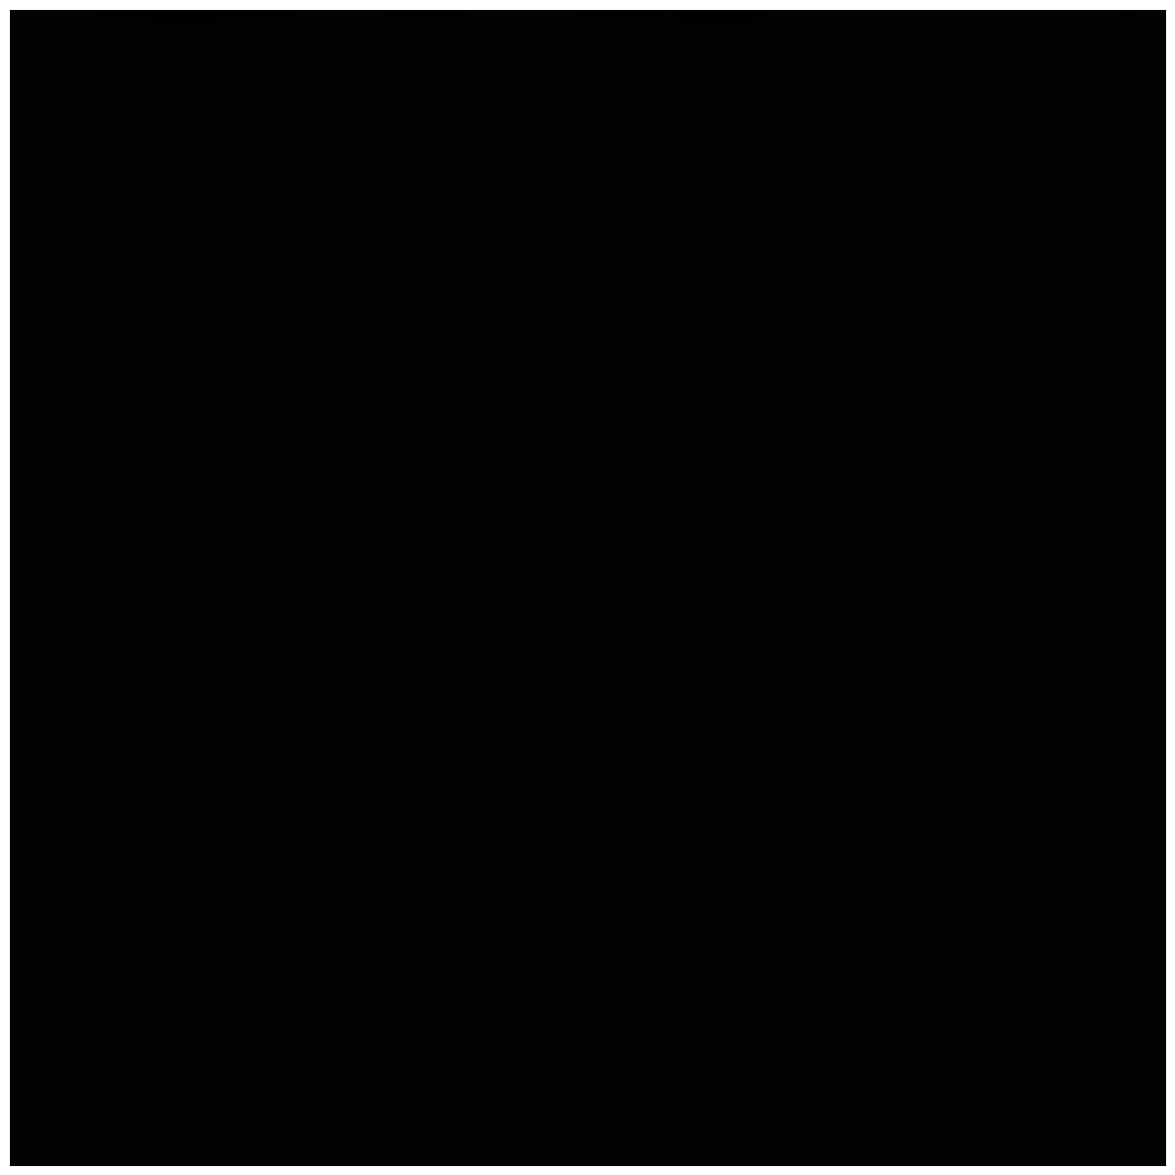

In [20]:
for y in range(0, 500, step_y):
    for x in range(0, 500, step_x):
        tile = large_image[y:y+tile_size[0], x:x+tile_size[1]]

        if tile is not None and tile.shape[0] == tile_size[0] and tile.shape[1] == tile_size[1]:

            # Add a batch dimension
    
            # Use model.predict on this 'tile'
            plot_image(tile, factor=3.5/255., clip_range=(0, 1))
            tile = np.expand_dims(tile, axis=0)
            segmented_tile = segment_tile(tile)
            plot_image(segmented_tile[0, :256, :256, :3], factor=3.5/255., clip_range=(0, 1))

            # Remove the batch dimension from the result

            # Paste the segmented tile into the segmentation map
            segmentation_map[y:y+tile_size[0], x:x+tile_size[1]][:, :, :] = segmented_tile  # Corrected

# Save or display the final segmentation map
cv2.imwrite('segmentation_map.jpg', (segmentation_map * 255).astype(np.uint8))  # Corrected save operation
plot_image(segmentation_map, factor=3.5, clip_range=(0, 1))  # Corrected plot_image parameters

In [ ]:
plot_image(segmentation_map[:2463, :2490, :3], factor=3.5/255., clip_range=(0, 1))
plot_image(segmentation_map[:2463, :2490, 3:6], factor=3.5, clip_range=(0, 1))

In [ ]:
import matplotlib.pyplot as plt

# Select the channel you want to visualize (e.g., class 0)
class_to_visualize = 0

# Extract the chosen channel
class_map = segmentation_map[:, :, class_to_visualize]

# Plot the chosen class
plt.imshow(class_map, cmap='viridis')  # You can change the cmap as needed
plt.colorbar()
plt.show()

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function for segmenting a tile (replace with your model)
def segment_tile(tile):
    return model.predict(np.expand_dims(tile, axis=0))  # Add a batch dimension

# Load the larger image
large_image = cv2.imread('ZapUkr_2023_08_31_36738247_47575448_37061005_47803009.tiff')  # Replace with your image path
tile_size = (256, 256)
overlap = 50  # Adjust the overlap as needed

# Initialize an empty segmentation map
segmentation_map = np.zeros((large_image.shape[0], large_image.shape[1], 6), dtype=np.float32)

# Define the step size for sliding the window
step_x = tile_size[1] - overlap
step_y = tile_size[0] - overlap

# Color mapping for classes
class_colors = {
    0: (60, 16, 152),  # Building
    1: (132, 41, 246),  # Land
    2: (110, 193, 228),  # Road
    3: (254, 221, 58),  # Vegetation
    4: (226, 169, 41),  # Water
    5: (155, 155, 155)  # Unlabeled
}

# Iterate through the image using tiles
for y in range(0, large_image.shape[0], step_y):
    for x in range(0, large_image.shape[1], step_x):
        tile = large_image[y:y+tile_size[0], x:x+tile_size[1]]

        if tile is not None and tile.shape[0] == tile_size[0] and tile.shape[1] == tile_size[1]:
            # Convert 'tile' to a PIL image for resizing
            tile_pil = Image.fromarray(cv2.cvtColor(tile, cv2.COLOR_BGR2RGB))
            tile_pil = tile_pil.resize((256, 256))np.expand_dims(
            tile = np.array(tile_pil)
    
            # Use model.predict on this 'tile'
            segmented_tile = segment_tile(tile)[0]  # Remove the batch dimension

            # Paste the segmented tile into the segmentation map with color coding
            for class_id, color in class_colors.items():
                segmentation_map[y:y+tile_size[0], x:x+tile_size[1], class_id] = segmented_tile[..., class_id]

# Create a color-coded segmentation map for visualization
color_coded_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8)

for class_id, color in class_colors.items():
    color_coded_map += (segmentation_map[..., class_id] > 0.5)[:, :, np.newaxis] * np.array(color, dtype=np.uint8)

# Save or display the color-coded segmentation map
cv2.imwrite('segmentation_map.jpg', color_coded_map)
plt.imshow(color_coded_map)
plt.axis('off')
plt.show()
